## Import Libraries

In [ ]:
# helper
from functools import wraps
import time

# math
import numpy as np
import scipy.io
import math
import cmath
import cvxpy as cp

#plotting
import matplotlib.pyplot as plt

## Helper Functions

We can sample the Channel coefficients from a rician distribution with parameters $\beta$ and $K$. $\mathbf{h_d}$ is constant and $\mathbf{h_s}$ is sampled form a circularly symmetric standard Complex Gaussian  
$$\mathbf{h} = \sqrt{\frac{\beta K}{1+K}} \mathbf{h_d} + \sqrt{\frac{\beta }{1+K}} \mathbf{h_s}$$

In [ ]:
# get the channel coefficients from the rician distribution
def rician(beta,k,h_d=0 ,num_carriers=500,num_channels=1):
    """
    returns a (num_carriers x num_channels) matrix with complex numbers whose magnitude would follow a rician distribution 
    beta is a distance dependent path loss parameter 
    K is ratio of deterministic to scattered power
    """
    det = math.sqrt(beta*k/(1+k))* h_d
    det = np.tile(det,(1,num_carriers)).T
    ran = math.sqrt(beta/((1+k)*2)) * np.random.randn(num_carriers, num_channels*2).view(np.complex128)
    return ran+det

In [ ]:
def theta_direct(N,phi=np.pi/3,d=0.06): 
    # What does phi mean again
    return 2*np.pi*d* np.arange(1,N+1)*np.cos(phi)
    
def theta_reflector(Nx,Ny,phi=np.pi/3,d=0.06/4): 
    # Nx = Number of columns in IRS
    # Ny = Number of rows
    # What is the significance of Phi here?
    yv,xv=np.meshgrid(np.arange(Nx),np.arange(Ny), sparse=False, indexing='ij')
    dist=np.sqrt(xv**2+yv**2)
    return 2 * np.pi * d * dist * np.cos(phi)

def generate_deterministic_direct(antenna_gains):
    
    alphas=np.sqrt(antenna_gains)
    return np.exp(1j*theta_direct(antenna_gains.shape[0]))*alphas

def generate_deterministic_reflectors(antenna_gains):
    alphas=np.sqrt(antenna_gains)
    return np.exp(1j*theta_reflector(antenna_gains.shape[0],antenna_gains.shape[1]))*alphas


In [ ]:
generate_deterministic_direct(np.ones(1))
generate_deterministic_direct(np.ones(1))


array([0.98228725+0.18738131j])

In [ ]:
# we can append @timer to each of our function for which we want to have the time printed
def timer(func):
    """
    Usage:
    @timer
    def somefunc(a,b):
        output = a+b
        return output
    """
    @wraps(func)
    def wrapper(*args,**kwargs):
        print(f"{func.__name__!r} begins")
        start_time = time.time()
        result = func(*args,**kwargs)
        print(f"{func.__name__!r} ends in {time.time()-start_time} secs")
        return result
    return wrapper

In [ ]:
# get IRS configuration
def get_config(method = None):
    if method == None:
        return np.exp(2j*np.random.randint(M,size=N_e)*np.pi/M)

In [ ]:
# calculate the datarate for the given configuration of IRS
def calculate_datarate(H,x):
    indi=np.log2(1+(np.square(np.abs(H)))*abs(np.square(x).sum())/10**-14)
    return np.sum(indi)*10**6

In [ ]:
# vector method
def return_coefficients(h_,opt,M=2):
    angles = M - np.round((np.angle(opt/h_)*M/(2*np.pi))%np.pi)
    angles[0] = 0
    return np.exp(2j*angles*np.pi/M)

def vector_heuristic(h,M=2):
    h_ = h.sum(axis=0)
    idx = np.argmax(np.abs(h_))

    return return_coefficients(h_,h_[idx],M)

In [ ]:
#Greedy approach
def return_greedy_estimate(estimation,N_regions=100,M=2):
    estimation_sum = estimation.sum(axis=0)
    opt = np.exp(2j*np.asarray(range(M))*np.pi/M)
    angles = np.ones((estimation_sum.shape[0],N_regions)).astype(complex)
    for i in range(len(opt)):
        angles[:,i] = return_coefficients(estimation_sum,opt[i],M)
    abso=np.abs(np.matmul(angles.T,estimation_sum.reshape((-1,1))))
    opt_angle=angles[:,np.where((angles[0,:]==1) &(abso==np.max(abso)))[0]][:,0].flatten()
    return opt_angle

In [ ]:
def strongest_tap(est,n_strong,N_e,K,L,N_regions=100,M=2):
    time_h = np.fft.ifft(est,K,axis=0)[:L,:]
    strongest_tap = np.argsort(np.abs(time_h),axis=0)[-1*n_strong:,:].reshape(N_e,n_strong)
    top_time_h = np.zeros((n_strong,N_e),dtype=complex)
    for i in range(N_e):
        top_time_h[:,i] = time_h[strongest_tap[i],i]
    h = np.fft.fft(top_time_h,500,axis=0) # FFT 
    theta = return_greedy_estimate(h,N_regions,M) # Try out different stats
    return theta

## System Parameters

In [ ]:
# General parameters
K = 500 # sub carriers
L = 20 # taps

M = 2 #Num of discrete phase-shifts
N_x = 16
N_y = 16
N_e = N_x * N_y #Number of IRS elements

# Channel information
#direct channel
beta_d = (10)**-3 * (10)**-3
k_d = 0
const_d = 0
#BS to IRS channel
beta_bi =  (10)**-3 * (1.5)**-3
k_bi = 1
const_bi = 0
#IRS to User channel
beta_iu =  (10)**-3 * (8)**-3
k_iu = 1
const_iu = 0

## Declaring variables

In [ ]:
det = generate_deterministic_reflectors(np.ones((N_x,N_y))).reshape((N_e,1))
det_direct = generate_deterministic_direct(np.ones(1))[0]
# CSI

H_d = rician(beta=beta_d, k=k_d,num_carriers=K,h_d=det_direct)
H_bi = rician(beta=beta_bi,k=k_bi,num_carriers=K,num_channels=N_e,h_d=det)
H_iu = rician(beta=beta_iu,k=k_iu,num_carriers=K,num_channels=N_e,h_d=det)

## Theta

IRS_config = get_config()
Direct = np.ones(1).astype(np.complex128)
Theta = np.concatenate((Direct,IRS_config)).reshape((N_e+1,1))


## Final channel
H_id = np.multiply(H_bi,H_iu)
H = np.concatenate((H_d,H_id), axis=1)
G_comp = H * Theta.T ## Channel Across different subcarriers and subchannels
G = H @ Theta ## Final  Channel across different subcarriers

def calculate_cascaded(H,Theta):
    Theta = Theta.reshape((N_e+1,1))
    G = H @ Theta ## Final  Channel across different subcarriers
    return G    





## Creating Signal 

In [ ]:
## Power Distribution over different subcarriers: 
P = np.random.dirichlet(np.ones(K),size=1)
P_max = 10 ## Power Budget in mW
## Symbol to be sent of 1mW
s = 1e-3 * P_max
w = G.copy()/(np.linalg.norm(s)*np.linalg.norm(G)) # Precoding Vector
x= w*s # Final Symbol Transmitted
x = x * P.T

In [ ]:
np.square(x).sum() ## VERIFY SIGNAL POWER!

(-3.741078089085031e-07+1.0626394036262645e-06j)

## Transmitting the Signal

In [ ]:
y = x * G 

## Data Rate Expression

In [ ]:
Theta = strongest_tap(H,1,N_e+1,K,L)
#Theta = vector_heuristic(H,M)
G = calculate_cascaded(H,Theta)
R = calculate_datarate(G,x)

In [ ]:
R/10**8

48.6599249573081

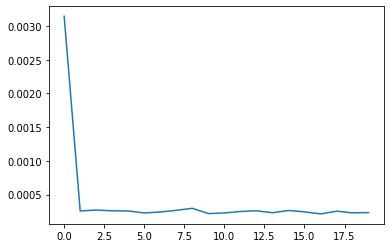

In [ ]:
time_h = np.fft.ifft(H,K,axis=0)[:L,:]
plt.plot(np.abs(time_h).sum(axis=1))
plt.show()

In [ ]:
np.abs(time_h).sum(axis=1)

array([0.00314554, 0.0002569 , 0.00027098, 0.00025916, 0.00025677,
       0.00022749, 0.00024154, 0.00026633, 0.00029646, 0.00021801,
       0.00022743, 0.00024901, 0.00026013, 0.00023071, 0.00026411,
       0.00024444, 0.00021318, 0.00025375, 0.00022946, 0.00023257])

In [ ]:
estimate = np.load("/work/IRS-Paper/estimate_d1.npy")

In [ ]:
estimate.shape

(500, 4097)

In [ ]:
N_e = 4096
#Theta = strongest_tap(estimate,1,N_e+1,K,L)
Theta = vector_heuristic(estimate,M)
G = calculate_cascaded(estimate,Theta)
R = calculate_datarate(G,x)

In [ ]:
R

0.6497864462046984

In [ ]:
N_e = 4096
Theta = strongest_tap(estimate,1,N_e+1,K,L)
# Theta = vector_heuristic(estimate,M)
G = calculate_cascaded(estimate,Theta)
R = calculate_datarate(G,x)

In [ ]:
R

0.616325838913862

## SDP Based Approach

In [ ]:
Ne=256
H_id = np.matrix(H_id)
H_d = np.matrix(H_d)
A_ = H_id.H @ H_id
u_ = H_id.H @ H_d
u_abs2 = np.multiply(u_,u_.conjugate())


In [ ]:
M_u = np.concatenate([A_, np.eye(Ne)], axis=0)
M_l = np.concatenate([np.eye(Ne),np.zeros_like(A_)], axis=0)
M_ = np.matrix(np.concatenate([M_u, M_l], axis=1))
W_ = cp.Variable(shape=(2*Ne,2*Ne), hermitian=True)


In [ ]:
# Define and solve the CVXPY problem.
# The operator >> denotes matrix inequality.
constraints = [W_ >> 0]
constraints += [
    cp.real(W_[i][i]) <= 1 for i in range(Ne)
]

constraints += [
    W_[i+Ne][i+Ne] == u_abs2[i] for i in range(Ne)
]
prob = cp.Problem(cp.Maximize(cp.real(cp.trace(W_ @ M_))),
                  constraints)

prob.solve(verbose=True, max_iters = 200)

In [ ]:
W_sub = W_.value[0:Ne,0:Ne]
w,v = np.linalg.eig(W_sub)
if np.linalg.matrix_rank(W_sub) ==1:
    theta_init = v @ np.sqrt(w).reshape(-1,1)
else:
    Q = 100
    phi = []
    prod = v @ np.diag(np.sqrt(w))
    P = []
    for q in range(Q):
        r = math.sqrt(0.5)*np.random.randn(256, 2).view(np.complex128).reshape(-1,1)
        phiq = np.exp(1j*np.angle(prod @ r))
        Pq = np.linalg.norm(H_d+ H_id@phiq)
        phi.append(phiq)
        P.append(Pq)
    theta_init = phi[[i for i,p in enumerate(P) if p ==max(P)][0]]

In [ ]:
a = np.real(H.sum(axis = 1))
b = np.imag(H.sum(axis = 1))

In [ ]:
a_init = np.random.randn()  
b_init = np.random.randn()  


In [ ]:
f = lambda a,b: a_init**2 + b_init**2 + 2*a_init*(a-a_init ) + 2*b_init*(b-b_init )

In [ ]:
type(f(1,2))

float

In [ ]:
x = cp.Variable(N_e,complex= True)
tau = 1
sigma = 10**-20
yn = cp.square(cp.abs(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,256)),H[:,1:]),axis=1)))
yn = cp.sum(cp.log1p(yn))
objective = cp.Maximize(-yn)


ValueError: Invalid reshape dimensions (1, 256).

In [ ]:
objective.is_dcp()

False

In [ ]:
a = np.real(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,256)),H[:,1:]),axis=1))
b = np.imag(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,256)),H[:,1:]),axis=1))

constraints = [cp.abs(x) <= 1,cp.abs(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,256)),H[:,1:]),axis=1)) <= f(a,b)  ]
#constraints = [cp.abs(x) <= 1]#,cp.abs(H[:,0]+cp.sum(cp.multiply(cp.reshape(x,(1,256)),H[:,1:]),axis=1)) <= cp.real(f(a,b))  ]


ValueError: Inequality constraints cannot be complex.

In [ ]:
prob = cp.Problem(objective, constraints)


In [ ]:
result = prob.solve()

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
log1p(power(abs([ 4.63481348e-05+6.79870589e-04j  4.73512199e-04+7.57610169e-04j
  6.42746091e-04+1.58764765e-05j -6.30854529e-04+1.85020010e-03j
  6.15105489e-04+2.50016781e-04j  3.25275062e-04-1.88906329e-05j
 -4.45466530e-04+8.34950901e-04j -9.90512337e-04+1.41879771e-04j
 -1.20301798e-04-9.22208542e-04j  1.35794907e-03-9.13264146e-04j
 -7.58424065e-05-9.56444470e-04j -1.45071155e-03-7.80327925e-04j
  7.17286070e-04+9.86854898e-04j -6.58993442e-04-3.85433138e-04j
 -3.99481444e-04-3.24344126e-05j -2.69573375e-04+7.14199667e-04j
  8.29329969e-05+4.61997618e-04j -5.14004214e-04+1.55195093e-03j
 -7.85820019e-04+6.62173467e-04j -1.48648513e-05-4.11100184e-04j
  9.10372288e-04+8.15668108e-04j  6.42380578e-05+5.88385140e-04j
  1.68577966e-05+6.90544726e-04j -3.19040242e-04-5.99306908e-04j
 -4.01812595e-04+6.56732700e-04j  2.42486175e-04-2.04865208e-04j
 -1.35107715e-03-9.03358587e-04j  5.73712045e-04-9.30853992e-04j
 -5.52766198e-05-3.13659281e-05j -7.48480165e-04+9.61048328e-05j
  9.39992853e-04-7.70265926e-05j -1.06378024e-03-1.30886510e-03j
  3.43641549e-04-1.37483266e-03j -2.93772514e-04+1.32716153e-03j
 -3.49949780e-04-9.03422540e-04j  2.38467734e-04+8.76137361e-04j
 -3.70597780e-04+5.20328875e-04j  8.13047274e-04-1.63104598e-03j
  1.03441921e-03-6.96571325e-04j  8.90204073e-05-1.93934857e-05j
  1.13622797e-04+3.99769828e-04j  1.30541487e-03-7.25438880e-04j
  6.19863558e-04+1.39959526e-03j -1.21916316e-04+1.27290622e-03j
  1.03709647e-03-5.15271646e-04j -3.39846151e-04-2.46642885e-05j
 -9.82772604e-04-8.69380767e-04j  4.68130742e-05+1.81714197e-04j
  2.81615621e-04-1.11516341e-03j -6.42032736e-04+2.52259855e-04j
 -2.72781758e-04-3.05860573e-04j  1.43819803e-03+1.17364042e-04j
  8.90460310e-04+1.31771426e-04j  5.71081972e-04+1.88680079e-04j
  5.71497960e-04+3.96335967e-05j -7.06724197e-04-7.34529462e-05j
  8.77661210e-04-1.19254384e-03j  6.55564129e-04+1.63269666e-04j
  9.03914602e-04+3.53213622e-04j  1.57256013e-04-6.42607760e-05j
 -2.98923263e-04-3.38234834e-04j  6.67828268e-04+2.51913854e-04j
 -9.20232696e-04-3.36372964e-05j  1.81626402e-04+1.08699095e-04j
  2.56696707e-04+2.21295223e-04j  1.35519794e-03-1.72173072e-03j
 -1.31620806e-03-4.23159179e-05j -2.20514687e-04+2.72022595e-04j
 -5.46005190e-05+4.31623171e-04j -6.42169720e-05+2.48845431e-04j
 -7.11894773e-04-4.14915973e-04j  2.44722326e-03-2.45988599e-05j
  2.86854043e-04-2.73501826e-04j  5.71148532e-04+2.30850746e-04j
  5.02747858e-05+3.22603942e-04j -4.64518368e-04+3.73774345e-04j
  1.10546501e-03-2.82900013e-04j  1.12052462e-03+2.57780130e-05j
  1.03513658e-03-2.77941314e-04j  1.58749030e-03+6.67783478e-05j
 -8.97050855e-04+1.05437188e-03j -8.99137885e-04-4.67130271e-05j
 -9.67497407e-04-9.24863137e-04j -7.25295059e-04-3.25272443e-04j
 -7.88719358e-05+8.76294047e-04j  3.88224745e-04-7.32963997e-04j
  4.44287329e-06-1.40510099e-03j -1.25392979e-03+1.23711732e-03j
  7.75068896e-04-7.04837882e-04j  1.33607902e-03+4.54482359e-04j
 -3.38168376e-04-1.99399758e-04j -5.71805581e-04-6.10060905e-04j
  9.21882682e-04-1.68870938e-03j -3.77261026e-04+6.92834224e-04j
  1.00393361e-03+3.70108586e-04j  7.57528032e-04-6.87485609e-04j
 -1.72326445e-03+2.24871400e-04j  2.54747326e-04+1.12111874e-03j
  5.11540755e-04-4.44653352e-04j -6.46307041e-04-1.26635149e-03j
 -1.02014649e-03+5.96689661e-04j -4.55662345e-04+9.14064936e-04j
  1.45199515e-04-1.22587613e-03j  6.84322241e-04-1.06771097e-03j
 -1.35245341e-04-5.10772016e-05j -8.08243350e-04-2.79752035e-04j
 -5.80725764e-04-1.10688690e-04j -1.34161438e-03+3.99032289e-05j
  3.24665270e-04+1.11572623e-03j -3.89458806e-04+1.05087271e-03j
  1.16490194e-03-7.35309182e-04j  2.15530007e-04-1.22292590e-03j
 -8.32520401e-04-5.26195332e-04j  1.11810342e-04-3.17447730e-04j
 -1.32430706e-03-9.19791257e-04j  4.81624631e-04-1.02748799e-03j
 -4.64014854e-04-8.23713168e-04j  1.00719789e-03-2.82541455e-04j
  7.34164786e-05+2.35573869e-04j  3.62907436e-04+1.25911222e-04j
 -1.18453301e-03-9.72705552e-04j -1.45580263e-04-1.44485807e-03j
  3.01017060e-04-8.86686372e-05j  3.23941305e-05-3.49485982e-04j
 -7.25858684e-04+8.03170751e-04j  9.47394002e-05+8.44647727e-04j
 -2.62578594e-04+2.86968483e-04j -8.06867000e-04+4.46611570e-04j
  1.11590739e-03+5.70768367e-04j -1.58326662e-04+1.14945908e-03j
 -1.43268470e-04+9.38318792e-05j  3.66007224e-04+3.63951650e-05j
 -4.64940452e-05-2.04061721e-04j -9.71581929e-04+9.74392284e-04j
 -9.58689492e-04-4.15789534e-04j  5.08287581e-04+1.48265527e-04j
 -1.05520346e-03-9.49910993e-04j  4.94365625e-04-5.43234014e-04j
  1.13179951e-04-1.99701337e-04j -5.28656495e-04+8.35646285e-04j
 -2.45883243e-04-1.07759063e-03j  1.87540354e-05+3.16638411e-04j
  1.65953441e-04-5.64082415e-05j  2.53278077e-04+1.51985279e-03j
  4.27352230e-04+1.02199867e-03j -5.26248616e-04+5.27283211e-04j
  6.80955190e-04+1.72581937e-03j -5.00135316e-04+2.21993272e-04j
 -1.24892072e-03+1.07040292e-03j  1.66102858e-04-6.09756845e-04j
  3.28912325e-04-2.65879288e-05j -6.28228219e-04+2.61347946e-04j
  1.51538330e-05-4.08941340e-04j  9.28074423e-04-2.05394055e-04j
  1.41043292e-03+5.54165292e-04j  6.79372330e-04-3.14772121e-05j
  1.21897500e-03+8.49981661e-04j -6.99500502e-04-7.62237558e-05j
  1.81587481e-04+2.54368725e-04j  1.66131817e-04-1.44518402e-03j
  4.78483510e-04-4.59233328e-04j  2.81024938e-04-1.11780628e-03j
 -4.21636696e-04-1.64757166e-04j -7.52853146e-04-1.80242697e-04j
  3.71013664e-04+1.26208887e-04j  4.09110952e-06+6.71398914e-04j
  6.25475789e-04+1.16575073e-05j -5.59812564e-04+1.86344491e-04j
  1.11970556e-03-1.00148694e-03j  5.19046074e-04-3.17810741e-04j
  4.93363844e-05+2.92246144e-04j -5.49066090e-04+3.10044689e-04j
  4.14063717e-05-3.17295125e-04j  5.52752533e-04-1.08573062e-03j
  3.84152468e-04-4.41309890e-04j  4.26618363e-04-7.64993766e-04j
  6.55159297e-04+4.28972488e-04j -8.34834724e-04+7.87667482e-04j
 -7.22812105e-05-8.93902496e-06j  1.91483101e-04-3.46022786e-04j
 -1.03422540e-03-1.02930251e-04j  3.40697891e-05+1.62533139e-03j
 -1.23698051e-03-3.19088909e-04j -3.18776298e-04+9.41891932e-04j
 -4.99176878e-05+3.63281965e-04j  3.34933067e-04-3.44532097e-04j
 -2.49995780e-04+5.37808347e-06j -9.40133321e-05+3.83858776e-04j
  3.97316577e-04-4.37969112e-04j  8.73220529e-04-1.07848463e-04j
 -2.96389179e-05+5.51801506e-04j  3.43137460e-04+1.38685602e-03j
 -5.54341452e-04+5.09364116e-06j  5.19037716e-04-2.72530953e-04j
  2.60713882e-04+1.39825432e-03j -3.84040934e-04-5.84807036e-04j
  1.48156299e-04+1.00289349e-03j -2.49553460e-03+1.18840298e-03j
  2.37167113e-04-1.09351362e-03j -6.58195113e-05-2.03028644e-04j
 -4.04436945e-04-5.97042455e-04j -9.43028238e-05-1.05613177e-03j
 -3.90711102e-04-6.06018826e-04j -1.38092422e-03+3.20872789e-04j
 -3.69733578e-04-4.34356159e-04j -4.15808649e-04-7.25537409e-04j
 -1.58652211e-04+7.69819998e-04j -3.85682494e-04+7.86644928e-04j
  8.28505139e-04+8.48317148e-04j -9.60686732e-04+4.49699867e-04j
  3.27541138e-04+5.13026257e-05j -2.61974557e-04-7.22748655e-04j
  6.19402958e-04-2.53924313e-04j  2.99511530e-04+2.60564533e-05j
 -2.09803749e-04+1.03469594e-04j -4.99788469e-05+3.16638641e-04j
 -9.29663130e-05+1.15269128e-03j -1.06823273e-03+5.91876775e-04j
 -6.33510862e-04+1.08406518e-03j  8.27094351e-04+1.49214391e-04j
 -5.92368985e-04+1.39667697e-03j -3.99787151e-04-9.42229420e-04j
  3.51022778e-04-9.09227833e-04j  2.40939275e-04+1.17780191e-03j
  2.27635025e-04+8.78837185e-04j  4.00118152e-04+1.17165338e-03j
 -1.12074738e-03+3.60345068e-04j -4.81809289e-04+9.38270759e-04j
  2.91473241e-04-1.40431088e-04j -5.18489023e-04+1.58200288e-04j
  1.23418493e-03-9.43220384e-04j -1.56158339e-03-1.07451678e-03j
  4.31416734e-04-2.82265717e-04j  1.91427798e-04-1.50170189e-04j
 -6.12542806e-04+1.13791061e-03j  8.93545921e-04-2.34484242e-05j
 -1.63031302e-03+4.66282501e-04j -8.52171700e-05-6.82866491e-06j
  4.15752717e-04+7.82987037e-04j -3.03653869e-05+1.10359685e-05j
 -1.98798615e-04+3.76529650e-04j  2.05184496e-04+7.36721239e-04j
 -1.80128896e-04-6.11148260e-06j  6.43313486e-04+3.18896316e-04j
  1.53020787e-04+8.45341106e-04j -4.64509288e-04-1.38077826e-03j
  2.53170092e-04+3.92403982e-05j -5.88025357e-05+7.67426726e-04j
 -9.48127878e-04-1.43484278e-03j  6.46517228e-04+1.20348721e-03j
 -2.39909902e-04-1.52356970e-04j  9.30401846e-04+9.02940378e-04j
  1.28286785e-03-2.47775321e-04j -4.88502594e-05+1.46835442e-04j
 -7.39162095e-04+2.56343915e-04j -1.06171970e-03-2.09734608e-04j
  4.44759747e-04+1.45602656e-05j -6.94288606e-04+5.05476233e-04j
  5.75224510e-04-1.02157174e-03j  1.04380000e-04+5.90061304e-04j
 -5.41294456e-04-6.43269288e-04j -4.53009280e-04+4.37687259e-04j
  1.93163276e-03-1.72497343e-03j -1.05229162e-04-2.14131905e-05j
  9.99338812e-04+4.91594310e-05j  5.28548617e-04+5.00060749e-05j
  3.15412002e-04-5.75376852e-04j -9.81577051e-04-4.16697618e-04j
  1.01724644e-03+1.09565593e-03j  1.13501016e-04-2.91796191e-04j
  1.24114529e-03-1.82106834e-03j -7.55959038e-04+1.03104303e-03j
  8.90994743e-04-4.30333509e-04j  4.42266737e-04+2.80235583e-04j
  6.80533640e-04-1.42467703e-03j -7.29492607e-04+2.35098385e-04j
 -3.27909790e-04-1.28126929e-03j  6.90842098e-04-4.12147019e-04j
 -3.22911762e-04+3.88226835e-04j  1.27632978e-04+1.17692374e-05j
 -3.66977404e-04-2.70083603e-04j -5.69581083e-04+1.41686115e-03j
  8.64159012e-04+1.82015766e-04j  1.12207718e-03-5.91654641e-04j
  8.92788493e-04+1.11458825e-03j -6.28468538e-04+1.10838364e-03j
  6.73475322e-04+6.27602729e-05j -9.76750143e-04-1.35516618e-04j
  3.07745537e-04+4.06843259e-04j -9.74044839e-05-3.53354388e-04j
  1.41938435e-04+3.30197681e-04j  3.70834541e-04-9.63997285e-04j
  4.10626654e-04+1.51853657e-03j  1.63849169e-03-4.10303731e-04j
 -6.05929681e-04+1.06836365e-03j -2.95068398e-04+2.25046445e-03j
 -1.11410671e-03+4.19645266e-04j  1.01175476e-05-1.79072696e-03j
 -1.18399092e-03-1.59631452e-05j -3.96993854e-04+2.91339749e-04j
  1.09249589e-04-1.26887277e-03j  1.01520470e-03-1.42312337e-03j
 -5.26812241e-04+8.98990590e-05j -3.86420190e-04+5.32271753e-04j
 -2.03221724e-04-3.86224525e-04j -5.38000140e-04+4.56734486e-04j
 -9.24139327e-05+5.09288454e-04j -1.47976250e-03-2.67371174e-04j
 -1.40548618e-04+2.64172849e-05j -4.07924662e-04+3.80698595e-04j
 -1.38655618e-03+1.74966868e-04j -3.70484446e-04-1.75634531e-05j
 -1.14544621e-03-7.34713725e-04j -2.69109135e-04-2.87177849e-04j
 -2.51046493e-04-1.73856218e-04j -1.51299545e-03-6.42745386e-04j
 -8.41978882e-04+5.06436753e-04j -3.20269446e-04-6.24625289e-04j
 -3.52591049e-04-7.11731208e-04j  2.49773224e-04+6.43994938e-04j
  2.25173379e-04-5.43388408e-04j -1.32615368e-03-5.65029679e-04j
  6.31129586e-04-2.93498831e-04j  1.14714805e-03-4.59351292e-05j
  7.99716179e-04+8.67301482e-07j -6.05733103e-04+1.13443181e-04j
  2.75145850e-04+6.91794124e-04j -1.54590921e-03+3.03714545e-04j
  2.05272284e-04-3.18342623e-05j  1.89723916e-04+1.52891726e-03j
 -4.28206794e-04+5.35975889e-04j -5.30301290e-04+7.76029669e-04j
 -1.22893012e-03-7.26173172e-04j -2.87033674e-04+6.26739634e-04j
  4.93988977e-04-1.59654755e-04j  4.54893895e-04-1.34812215e-04j
  1.40626041e-04-5.99814104e-04j  2.77136255e-04+1.41759686e-03j
  5.32761403e-04-2.29587087e-04j -6.87955803e-04-6.35423480e-04j
  1.32709566e-03-4.84085266e-04j -2.07814091e-03+2.87484571e-04j
  1.19321864e-05-8.51010598e-04j -2.69980451e-04+6.87371178e-05j
  2.77495246e-05+9.47126937e-04j -2.36538307e-04+4.43737855e-04j
 -1.49433435e-03-8.08478853e-04j  8.23057383e-04+4.01628814e-04j
 -1.63346612e-03-4.37169025e-04j -1.01163262e-03+1.34493573e-04j
  1.77454483e-03-8.18684112e-04j  7.43072588e-04-1.06115034e-03j
  9.95787775e-04-2.02043746e-03j -1.57339624e-03+5.58765642e-04j
  5.85713745e-04+6.97430263e-04j  2.63390067e-04-1.27447319e-04j
 -6.12706839e-04-9.75036564e-04j  3.39562860e-04+3.36057019e-05j
  9.68082440e-04+2.97057057e-04j  7.31158268e-04-2.99877996e-04j
 -9.65228678e-04-8.27747984e-04j  3.20634171e-04+5.01554334e-04j
  2.88549012e-04+1.51077969e-04j  8.24253202e-04-7.22843613e-04j
  1.35530461e-04+1.95555733e-04j  6.39717865e-04-3.11585947e-05j
  4.14719465e-04+6.85716531e-04j  8.50577740e-04+3.58840684e-04j
 -1.24143253e-03-4.38981660e-04j  2.28186280e-04-1.13054811e-03j
  9.58703464e-04-7.10560434e-05j -4.70546567e-04-4.23114659e-04j
  1.32773911e-03-3.64169040e-04j  1.25285695e-03+3.75030103e-04j
 -1.32061974e-03+1.21068514e-03j -1.73796428e-03-9.78011171e-04j
 -2.21150145e-04+6.87135471e-04j -5.13107426e-04-2.75438802e-04j
 -2.15076745e-04-1.26491462e-03j  6.75966307e-04+6.47698886e-04j
 -1.84890710e-04-9.04924184e-04j  3.48210798e-04+3.36911052e-04j
  9.64823605e-04+3.87965742e-04j  1.43929812e-03-1.43817988e-03j
 -3.16536227e-04-9.06147512e-04j  1.40811982e-04+5.30636184e-04j
 -6.53099126e-05+1.02355020e-03j  7.24635258e-04-6.76870308e-04j
 -6.53174356e-04-8.58542730e-04j  3.62392986e-04-1.79605707e-03j
 -3.41318452e-04-3.30823355e-04j -5.48633989e-06+1.00912110e-03j
  7.31641505e-04+1.73616698e-04j  1.90565718e-04-8.13755270e-04j
 -2.37926058e-04-3.56284559e-06j  1.92803420e-04+9.79386705e-04j
  1.79169109e-03+1.88541483e-04j  8.60276400e-04+1.22488395e-04j
 -7.79404317e-04+7.09901779e-04j  8.79565605e-05-6.89731357e-04j
 -9.57232228e-04-1.02067798e-03j -1.06581041e-03-3.13707425e-04j
  1.15282296e-03+5.70571087e-04j  4.40286061e-04-6.34089772e-04j
  2.06364686e-04-4.44550628e-04j -5.73892190e-04+4.81346694e-04j
 -1.04854038e-03-6.74514210e-04j -9.68380237e-04+2.45175862e-04j
 -1.13237670e-03-7.78074320e-04j  3.17408666e-04-4.57041809e-04j
  2.53045691e-04-1.10016827e-03j -5.98288413e-04+4.31885878e-04j
  1.79508995e-03-4.81130384e-04j -9.17952239e-04+7.62411285e-04j
 -8.59858150e-04+1.19054395e-04j  9.08260356e-04-1.99334880e-04j
  6.43645210e-04+3.38367382e-04j -4.42061676e-04+2.78857158e-05j
 -7.00092871e-04-2.71904782e-04j  7.52821546e-05-4.50544163e-06j
  2.36331983e-04+1.05084326e-04j -1.00746492e-03-4.09752307e-04j
  8.31505390e-04-5.72023028e-04j  1.15692425e-03-9.12474450e-04j
 -1.25142539e-03-1.39113177e-03j  5.09061529e-04-2.31048654e-04j
  1.52375171e-03+3.68407265e-04j -1.57524305e-04+2.79283761e-04j
  8.34844383e-05+2.49261043e-04j  2.15225114e-04-5.64904886e-04j
 -2.05210515e-04+4.65359403e-04j -3.75205887e-04-8.48783083e-04j
  1.72894034e-04-3.67615677e-04j  6.16903734e-04-6.04343298e-04j
  1.28963423e-03-2.06887880e-04j -2.94789305e-04+1.19895592e-03j
 -4.43871229e-04+5.47636306e-04j -2.10364004e-05+2.24157039e-04j
 -3.36852338e-04-4.09996930e-05j -8.73833915e-04+5.81905709e-04j
  1.07112049e-04+1.05130859e-03j  1.05382424e-03-3.15357229e-04j
 -1.66287382e-03+2.65746159e-05j  1.03407038e-04+2.26222143e-04j
  3.49818426e-04-5.32472661e-04j -1.18384017e-03+1.30142671e-04j
  1.17571007e-03+1.02022611e-04j  3.10813904e-04-5.18322832e-04j
 -2.45390562e-04-7.67147601e-04j -3.58052519e-04+1.20106622e-03j
 -9.11356841e-05+8.33353574e-04j  1.66518847e-04-7.61142160e-05j
  3.83411965e-04-3.11260542e-04j -8.81798025e-05+6.37592682e-04j
  6.14843045e-04-4.51252485e-04j  4.74349173e-04+2.70502911e-04j
 -6.30351378e-04-7.32787052e-04j -2.71041022e-04+1.68452984e-04j
 -3.61195264e-04+1.23850685e-03j  2.05340700e-03+7.25998924e-04j
 -7.64299422e-04+2.50487409e-04j  6.15218841e-04+2.71645341e-05j
 -5.46736553e-04-2.79301366e-05j  4.85812266e-04+1.96171871e-04j
  1.14130940e-04-2.08396630e-04j -1.11890822e-03-3.69783461e-04j
  9.25379095e-04-2.32362756e-04j -2.11654897e-04-1.43575535e-05j
 -9.22325988e-04-1.17772148e-03j -1.57248557e-03-8.89445439e-04j
 -4.02693031e-04-7.08286319e-04j -1.02951947e-04-4.28168917e-04j
 -7.03329262e-04+7.49168994e-05j  6.47379538e-04+8.46978944e-05j
 -1.01732572e-03-5.59670577e-04j -3.63696222e-04-7.54290845e-04j
 -2.27642256e-04-4.08095887e-04j -7.48680760e-04-7.79787243e-04j
 -6.75545941e-05+1.95748548e-04j -2.84541318e-04-1.71813509e-04j
  1.67081465e-04+6.12278437e-04j -9.56289441e-05+9.64237958e-04j
 -1.01797220e-03+9.31101888e-04j  4.76324784e-04+9.21132561e-04j
 -1.61978356e-03+1.83457654e-04j  8.11700758e-04-4.53586772e-04j
  6.00790692e-04-1.98170296e-05j  6.27936463e-04-4.07487886e-05j
 -2.80730099e-05-2.78629516e-04j -1.30680897e-04+3.31288057e-04j
 -4.96004036e-04-1.00544048e-03j  4.05433414e-04+7.82961637e-04j
  1.15056959e-03+7.79511014e-04j  4.71464411e-04-7.08378013e-04j
  2.93751758e-04+3.50462115e-04j -3.80655999e-04-8.97115374e-04j
  3.55289567e-04+5.38036204e-04j -3.09055892e-04-1.62426882e-03j
 -2.31574901e-04+6.77389675e-04j  1.28572823e-04-1.14642113e-03j] + Sum([[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]] @ reshape(var330, (1, 256), F) @ [[-6.81965459e-07+3.31098142e-06j  2.75415829e-06+3.80757506e-06j
  -5.67673492e-06+7.93845852e-06j ...  1.12415210e-06-8.02192584e-06j
   2.12323158e-05+3.72296450e-05j  1.73462671e-05+9.65365512e-06j]
 [-8.35989198e-06-2.04075096e-06j  2.23168880e-05+2.73793582e-05j
   2.49249324e-05-1.36313956e-05j ... -1.14144353e-05+8.44844973e-06j
   5.24285169e-07+2.40185571e-05j -1.39667036e-05+8.44574505e-06j]
 [ 2.33399540e-05-6.18290842e-06j  4.03062498e-06-1.11008619e-06j
   8.80886378e-06-1.95563262e-05j ... -5.66139794e-06+4.18002009e-06j
  -8.95574250e-07+2.87294168e-05j  4.12589974e-06+1.36463156e-05j]
 ...
 [ 1.38066069e-05+5.25498338e-06j -3.14011814e-05-2.24087235e-05j
  -3.53021881e-06+1.36124707e-05j ...  1.95939143e-05+3.34175999e-05j
   4.93621949e-06-3.06515554e-06j -3.20477105e-08+3.52080559e-05j]
 [ 2.69778202e-06-2.43179498e-06j -9.83699239e-07+8.91106805e-07j
   1.15743773e-05+3.90532797e-05j ... -1.98097163e-06+2.33286312e-07j
   5.07460732e-07+8.09983898e-06j -5.20901756e-05-1.05690909e-05j]
 [ 3.25696098e-05-5.21767435e-06j  3.19545605e-06-2.92690705e-06j
   8.55927206e-06+2.19162409e-05j ... -4.09053053e-06+5.68827892e-05j
   2.62765570e-06+1.44133696e-05j -8.73401555e-06+1.48241013e-05j]], 1, False)), 2.0))

In [ ]:
thetas = np.ones(N_e)
thetas[np.angle(x.value,deg= True)<0] = -1 

In [ ]:
ThetaSDP = np.concatenate([[1],thetas])

In [ ]:
G = calculate_cascaded(H,ThetaSDP)
RSDP = calculate_datarate(G,x)

In [ ]:
R/10**8

45.55753827956986

In [ ]:
RSDP/10**8

24.088598980286378

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4b319ffc-f2ce-4490-9e28-3a7eb21abad0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>